In [226]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from scipy import stats
from keras.preprocessing import sequence
from keras.layers import  Input, Dense, Flatten, Add,\
    BatchNormalization, Concatenate, Dropout, Activation, Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model, load_model
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
import keras.backend as K

In [227]:
from sklearn.metrics import roc_auc_score
class ROCCallBack(Callback):
    def __init__(self,training_data,validation_data):
        super().__init__()
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        y_pred_val = self.model.predict(self.x_val)
        roc_train, roc_val = [], []
        for counter, i in enumerate(output_names):            
            roc_train.append(roc_auc_score(self.y[counter], y_pred[counter].flatten()))            
            roc_val.append(roc_auc_score(self.y_val[counter], y_pred_val[counter].flatten())) 
        print()
        print('roc-auc: %s - roc-auc_val: %s' % (str(round(np.mean(roc_train),4)),str(round(np.mean(roc_val),4))))
        print('Val ROCs: ' + '    '.join([output_names[counter] + ': ' + str(round(i,4))for counter, i in enumerate(roc_val)]))

In [228]:
def flatten(x):
    if isinstance(x, (np.ndarray, list, tuple, pd.Series)):
        lst = []
        for i in x:
            lst += flatten(i)
        return lst
    else:
        return [x]

#### Load Data

In [229]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [230]:
# use linear preds as pseudo-labeled data
linear_preds = pd.read_csv('data/answers/linear_ensemble_0.85_09724.csv')

In [231]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [232]:
train[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [233]:
output_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [234]:
train['tokens'] = train['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))
test['tokens'] = test['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))

In [235]:
train['tokens'].head()

0    [explanation, why, the, edits, made, under, my...
1    [d'aww, !, he, matches, this, background, colo...
2    [hey, man, ,, i, 'm, really, not, trying, to, ...
3    [``, more, i, ca, n't, make, any, real, sugges...
4    [you, ,, sir, ,, are, my, hero, ., any, chance...
Name: tokens, dtype: object

In [236]:
train['tokLength'] = train['tokens'].apply(lambda x: len(x))

In [237]:
train['tokLength'].describe()

count    159571.000000
mean         80.322201
std         120.769777
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4948.000000
Name: tokLength, dtype: float64

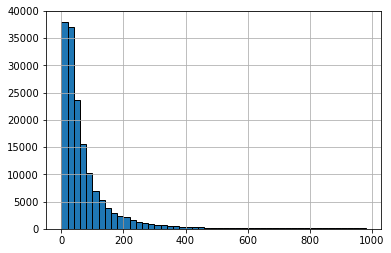

In [238]:
train['tokLength'].hist(bins = range(0, 1000, 20),linewidth = 1, edgecolor = 'black' )
plt.show()
#looks like max_length of 500 should be good

In [239]:
stats.percentileofscore(train['tokLength'].values, 500)

98.256575442906296

In [240]:
max_length = 500

What are the most common words in the texts?

In [241]:
dist = nltk.FreqDist(flatten(train.tokens.values))

In [242]:
print('Number of total tokens in the training set:', dist.N())
print('Number of unique tokens in the training set:', dist.B())

Number of total tokens in the training set: 12817094
Number of unique tokens in the training set: 259285


In [243]:
dist.most_common(n=50)

[('.', 502031),
 ('the', 495401),
 (',', 471812),
 ('to', 296851),
 ("''", 242526),
 ('i', 236559),
 ('of', 224008),
 ('and', 222709),
 ('you', 216674),
 ('a', 214116),
 ('is', 180287),
 ('that', 160512),
 ('``', 155372),
 ('it', 147625),
 ('in', 144392),
 ('!', 105576),
 ('for', 102451),
 ('this', 96943),
 ('not', 96581),
 (')', 90711),
 ('on', 89409),
 ('(', 85085),
 ('be', 83326),
 (':', 82772),
 ('as', 77269),
 ('have', 73939),
 ('are', 73404),
 ('?', 71692),
 ("'s", 66767),
 ('your', 63258),
 ('do', 62602),
 ('with', 59498),
 ('if', 58363),
 ("n't", 57137),
 ('article', 56859),
 ('was', 56537),
 ('or', 52514),
 ('but', 50938),
 ('page', 45656),
 ('my', 45520),
 ('wikipedia', 45418),
 ('an', 44513),
 ('from', 41411),
 ('by', 41040),
 ('at', 39430),
 ('can', 37244),
 ('about', 37043),
 ('me', 37025),
 ('so', 35968),
 ('what', 35291)]

#### Load GloVe

In [244]:
f = open('data/glove.42B.300d.txt', 'r', encoding = 'utf-8')

In [245]:
all_unique_tokens = set(flatten(train.tokens.values)).union(set(flatten(test.tokens.values)))

In [246]:
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    # Whole GloVe embeddings doesn't fit in my GPU memory, so only take words which appear in data for now. 
    # Can always swap weights for embedding layer after model training
    if word in all_unique_tokens:
        coefs = np.array(values[1:], dtype = 'float32')
        embeddings[word] = coefs

In [247]:
np.random.seed(10)
embeddings['<UNK>'] = np.random.normal(scale = 0.6,size = embeddings['.'].shape)

What are the most common words not in the vocab?

In [248]:
notInVocab = []
for i in dist.most_common():
    if i[0] not in embeddings.keys() and i[1]>100:
        notInVocab.append((i[0], i[1]))

In [249]:
notInVocab

[('•', 5300),
 ('==', 3145),
 ('~~~~', 1472),
 ('style=', 1303),
 ('·', 1109),
 ('|-', 868),
 ('*', 730),
 ('f5fffa', 713),
 ('..', 683),
 ('width=', 667),
 ('|style=', 635),
 ('====', 627),
 ('yourselfgo', 621),
 ('—preceding', 540),
 ('border:1px', 523),
 ('//en.wikipedia.org/w/index.php', 471),
 ("'image", 420),
 ('philippineslong', 420),
 ('cellpadding=', 372),
 ('pro-assad.hanibal911you', 345),
 ('bitches.fuck', 333),
 ('deneid', 331),
 ('rice=', 330),
 ('three-revert', 328),
 ("'fuck", 325),
 ('\u200e', 321),
 ('pagedelete', 312),
 ('|class=', 308),
 ('notrhbysouthbanof', 308),
 ('→', 307),
 ('mainpagebg', 304),
 ('//', 304),
 ('an/i', 292),
 ('admin-', 289),
 ('criminalwar', 279),
 ('bunksteve', 278),
 ('||', 269),
 ('marcolfuck', 260),
 ('boymamas', 258),
 ('penis/////small', 249),
 ("'the", 244),
 ('edgar181', 236),
 ('//en.wikipedia.org/wiki/wikipedia', 228),
 ('tommy2010', 228),
 ('securityfuck', 227),
 ('edit-warring', 224),
 ('bastered==bastered', 217),
 ('youbollocks', 21

#### Data Preparation

In [250]:
idx2word = {count:i for count, i in enumerate(embeddings.keys())}
word2idx = {idx2word[i]: i for i in idx2word.keys()}

In [251]:
print(word2idx['testing'])
print(word2idx['<UNK>'])
print(idx2word[123])

1674
211860
could


In [252]:
n_factors = 300
vocab_size = len(embeddings)

In [253]:
zero_vector_idx = vocab_size #place blank character last
idx2word[zero_vector_idx] = ''
word2idx[''] = zero_vector_idx

In [254]:
def create_emb():
    emb = np.zeros((vocab_size+1,n_factors), dtype = 'float32')
    for i in range(0, vocab_size):
        word = idx2word[i]
        emb[i,:] = embeddings[word] #each row is a word
    return emb

In [255]:
emb = create_emb()

In [256]:
emb.shape

(211862, 300)

In [257]:
# parse train/test sets
table = str.maketrans("","", string.punctuation)
def toksToInds(listToks):
    ans = []
    for count, i in enumerate(listToks):
        try:
            ans.append(word2idx[i])
        except KeyError:
            temp = i.translate(table)
            if temp and temp in word2idx.keys():
                ans.append(word2idx[temp])
            else:
                ans.append(word2idx['<UNK>'])        
    return np.array(ans)

train['idxInput'] = train['tokens'].apply(toksToInds)
test['idxInput'] = test['tokens'].apply(toksToInds)

In [258]:
# train test split
np.random.seed(10)
indexTrain = np.random.choice(range(train.shape[0]), size = int(0.9*train.shape[0]), replace = False)
indexVal = list(set(range(train.shape[0])) - set(indexTrain))
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [259]:
# only add pseudo labeled data to the training set
pseudo = test.merge(linear_preds, how = 'left', on='id').sample(int(train.shape[0]*0.3), random_state = 10).round()
pseudo[output_names] = pseudo[output_names].astype(int)
traindf = traindf.append(pseudo, ignore_index = True).sample(frac=1, random_state = 10).reset_index(drop = True)

In [260]:
dataInputTrain = sequence.pad_sequences(traindf['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
dataInputVal = sequence.pad_sequences(valdf['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
dataInputTest = sequence.pad_sequences(test['idxInput'].values, maxlen = max_length, value = zero_vector_idx)

In [261]:
dataInputTrain.shape

(191484, 500)

In [262]:
' '.join([idx2word[i] for i in dataInputTrain[0,:]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  . you have a quote , i have multiple full length articles , video , and a minimum of 20 quotes that say he is used gay slurs as a longer trend of prejudice'

In [263]:
valdf[output_names].apply(lambda x: pd.value_counts(np.round(x)))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,14401,15793,15111,15916,15150,15816
1,1557,165,847,42,808,142


#### Modelling

In [264]:
# simple starter
# vec_input = Input(shape = (max_length,))
# x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = MaxPooling1D(2)(x)
# # x = Dropout(0.2)(x)

# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dropout(0.5)(x)

# x = Dense(32, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# x = Dense(len(output_names), activation = 'sigmoid')(x)

# model = Model(inputs = vec_input, outputs = x)
# model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
# model.summary()

In [265]:
vec_input = Input(shape = (max_length,))
x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
x = BatchNormalization(axis = -1)(x)
#conv 1
x = Conv1D(32, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 2
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 3
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 4
x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

# #conv 5
# x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
# x = BatchNormalization(axis = -1)(x)
# x = MaxPooling1D(pool_size = 2)(x)
# x = Dropout(0.2)(x)

#dense 1
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

#dense 2
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

In [266]:
# add output layers
outputs = []
for i in output_names:
    intermediate_act = Dense(units = 128, activation = 'relu')(x)
    intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    if i in ['toxic','obscene']:
        intermediate_act = Dense(units = 512, activation = 'relu')(intermediate_act)
        intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    outputs.append(Dense(units = 1, activation = 'sigmoid', name = i)(intermediate_act))

In [267]:
model = Model(inputs = vec_input, outputs = outputs)

In [268]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 500, 300)     63558600    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 500, 300)     1200        embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 500, 32)      67232       batch_normalization_31[0][0]     
__________________________________________________________________________________________________
batch_norm

In [269]:
model.compile(Adam(1e-5), loss = 'binary_crossentropy')

In [270]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights/cnn_mdl', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
tensor_board = TensorBoard(log_dir='./logs/run1', write_graph = False,)
roc_callback = ROCCallBack(training_data = [dataInputTrain, [traindf[i] for i in output_names]],
                          validation_data = [dataInputVal, [valdf[i] for i in output_names]])

In [271]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 200, validation_data = [dataInputVal, [valdf[i] for i in output_names]],
         callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tensor_board, roc_callback])

Train on 191484 samples, validate on 15958 samples
Epoch 1/200
191424/191484 [============================>.] - ETA: 0s - loss: 0.5682 - toxic_loss: 0.1766 - severe_toxic_loss: 0.0543 - obscene_loss: 0.1176 - threat_loss: 0.0385 - insult_loss: 0.1237 - identity_hate_loss: 0.0575
roc-auc: 0.9543 - roc-auc_val: 0.9528
Val ROCs: toxic: 0.9625    severe_toxic: 0.975    obscene: 0.9561    threat: 0.9219    insult: 0.9622    identity_hate: 0.9393
191484/191484 [==============================] - 322s 2ms/step - loss: 0.5682 - toxic_loss: 0.1766 - severe_toxic_loss: 0.0543 - obscene_loss: 0.1176 - threat_loss: 0.0385 - insult_loss: 0.1236 - identity_hate_loss: 0.0575 - val_loss: 0.6443 - val_toxic_loss: 0.2015 - val_severe_toxic_loss: 0.0337 - val_obscene_loss: 0.1604 - val_threat_loss: 0.0157 - val_insult_loss: 0.1944 - val_identity_hate_loss: 0.0385
Epoch 2/200
191424/191484 [============================>.] - ETA: 0s - loss: 0.3652 - toxic_loss: 0.1253 - severe_toxic_loss: 0.0273 - obscene_l

Examining what the model got wrong

In [ ]:
pred_val = model.predict(dataInputVal)

In [332]:
# for count,i in enumerate(output_names):
#     print('---------------' + i + '---------------------')
#     dif = (valdf[i] - pred_val[count].flatten()).abs().sort_values(ascending = False)
#     most_dif = valdf.loc[dif.index[:2]]
#     for count2, j in enumerate(most_dif.iterrows()):
#         print('Predicted', pred_val[count].flatten()[valdf[i].index.get_loc(j[0])]
#               , 'Actual', j[1][i],
#              '\n',
#              j[1]['comment_text'])

#### Submission

In [272]:
pred = model.predict(test_mat)

In [273]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()

In [274]:
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/cnn1.csv', index = False)

In [275]:
model_stopped = load_model('weights/cnn_mdl')

In [276]:
pred_stopped = model_stopped.predict(test_mat)

In [277]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/cnnStopped.csv', index = False)    